# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. Because this tutorial uses 3D feature detection, you must use the v1.5 (3D and PBC changes) of *tobac*. 


This tutorial requires the use of pre-gridded radar data, which we generated during the Py-ART tutorial.

#### Imports

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pyart
import glob
import datetime
import matplotlib.gridspec as gridspec
import pandas as pd
import os
import math
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [61]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import IPython

### DATA INPUT:
https://tobac.readthedocs.io/en/latest/data_input.html

We use the gridded data from the Py-ART tutorial.

In [62]:
# gridded_files = sorted(glob.glob("../../data/uah-armor/gridded/*.nc"))
# gridded_files = sorted(glob.glob("/Users/kelcy/DATA/20080411/RAW_*grid.nc"))

In [63]:
# path = "/Users/kelcy/DATA/20080411/"

In [64]:
# #Read the data that is in antenna coordinates for all radars
# all_radar_gridded = dict()
# for radar_file_name in sorted(glob.glob(path+"*grid.nc")):
#     radar_time_str = radar_file_name.split('_')[-2]#[:-3]
#     radar_time  = datetime.datetime.strptime(radar_time_str, '%Y%m%d%H%M%S')
#     all_radar_gridded[radar_time] = pyart.io.read_grid(radar_file_name)
#     data = pyart.io.read_grid(radar_file_name)

# all_xr_grids = list()
# for radar_time in all_radar_gridded:
#     all_xr_grids.append(all_radar_gridded[radar_time].to_xarray())
    
# all_xr_data = xr.concat(all_xr_grids, 'time')
# all_xr_data.to_netcdf(path+"20080411_all_gridded.nc")
# # all_xr_data = xr.open_dataset(path+"all-data-gridded.nc")

In [65]:
# ds = xr.open_mfdataset(gridded_files).squeeze()
# ds

In [66]:
morton_data = '/Users/juliabman/Desktop/05232022_cd/morton_test_grid3.nc'

In [67]:
morton_data_xr = xr.open_mfdataset(morton_data)

In [68]:
morton_data_xr

<xarray.Dataset>
Dimensions:                       (time: 60, z: 31, y: 201, x: 201)
Coordinates:
  * time                          (time) datetime64[ns] 2022-05-23T20:04:15.9...
  * z                             (z) float64 0.0 66.67 ... 1.933e+03 2e+03
    lat                           (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
    lon                           (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
  * y                             (y) float64 -1.5e+05 -1.485e+05 ... 1.5e+05
  * x                             (x) float64 -1.5e+05 -1.485e+05 ... 1.5e+05
Data variables:
    cross_correlation_ratio       (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    differential_phase            (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    reflectivity                  (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    differential_reflectivity     (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    clutter_filter_power_removed  (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    velocity                      (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    spectrum_width                (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    ROI                           (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>

##### *tobac* is designed to work with **gridded** data currently, so using pre-gridded data, or data we must first grid the radial radar data. This is a quick and dirty gridding, but it will get the job done for this tutorial. Much better gridding results could be had with tuning of the parameters. 


#### Let's Look at the data - there's a number of ways to do a quick look, we're going to use pcolormesh. We can look at a specific level of the data, or create a composite reflectivity. Let's do both!

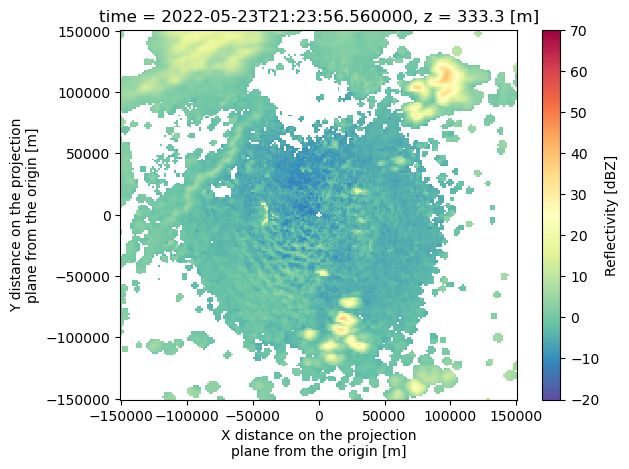

In [70]:
#Looking at a specific level and time of our data
morton_data_xr.reflectivity.isel(time=10, z=5).plot(cmap='Spectral_r', vmin=-20, vmax=70)

In [24]:
#QUICK COMPOSITE REFLECTIVITY HERE:
maxrefl = morton_data_xr['reflectivity'].max(dim='z')

In [25]:
maxrefl

<xarray.DataArray 'reflectivity' (time: 60, y: 201, x: 201)>
dask.array<_nanmax_skip-aggregate, shape=(60, 201, 201), dtype=float32, chunksize=(60, 201, 201), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-05-23T20:04:15.913000 ... 2022-05-24T...
    lat      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
  * y        (y) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05
  * x        (x) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05

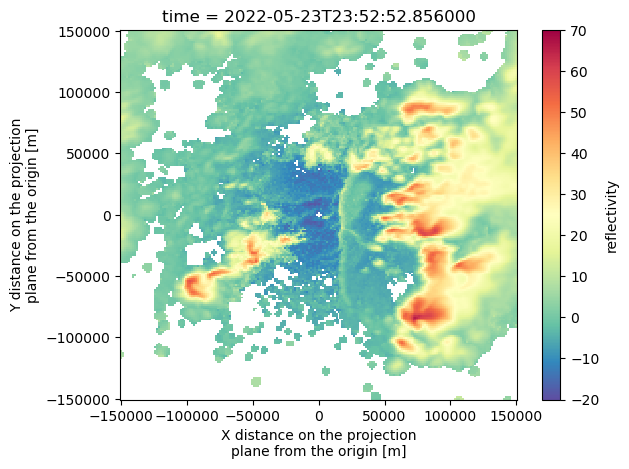

In [78]:
maxrefl.isel(time=30).plot(cmap='Spectral_r', vmin=-20, vmax=70)

###### Load in *tobac*

In [27]:
import tobac
import tobac.testing
import tobac.feature_detection
import tobac.segmentation

In [28]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4

In [29]:
morton_data_xr

<xarray.Dataset>
Dimensions:                       (time: 60, z: 31, y: 201, x: 201)
Coordinates:
  * time                          (time) datetime64[ns] 2022-05-23T20:04:15.9...
  * z                             (z) float64 0.0 66.67 ... 1.933e+03 2e+03
    lat                           (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
    lon                           (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
  * y                             (y) float64 -1.5e+05 -1.485e+05 ... 1.5e+05
  * x                             (x) float64 -1.5e+05 -1.485e+05 ... 1.5e+05
Data variables:
    cross_correlation_ratio       (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    differential_phase            (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    reflectivity                  (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    differential_reflectivity     (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    clutter_filter_power_removed  (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    velocity                      (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    spectrum_width                (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>
    ROI                           (time, z, y, x) float32 dask.array<chunksize=(60, 31, 201, 201), meta=np.ndarray>

Note that to track in 3D, we must give information about what our height coordinate is. Iris tends to be picky about the naming conventions, so we need to assign standard names as well.

In [30]:
morton_data_xr.z.attrs["standard_name"] = "altitude"
morton_data_xr.lat.attrs["standard_name"] = "latitude"
morton_data_xr.lon.attrs["standard_name"] = "longitude"

# morton_data_xr.z.attrs["standard_name"] = "altitude"
# morton_data_xr.radar_latitude.attrs["standard_name"] = "latitude"
# morton_data_xr.radar_longitude.attrs["standard_name"] = "longitude"

xr_grid_full = morton_data_xr["reflectivity"]

In [31]:
xr_grid_full

<xarray.DataArray 'reflectivity' (time: 60, z: 31, y: 201, x: 201)>
dask.array<open_dataset-reflectivity, shape=(60, 31, 201, 201), dtype=float32, chunksize=(60, 31, 201, 201), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-05-23T20:04:15.913000 ... 2022-05-24T...
  * z        (z) float64 0.0 66.67 133.3 200.0 ... 1.867e+03 1.933e+03 2e+03
    lat      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
  * y        (y) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05
  * x        (x) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    valid_max:      94.5
    valid_min:      -32.0

In [32]:
#Even though we read in our data using Xarray, and Xarray is our data handler of choice (could also be Pandas)
#we need to conver this data to iris cubes. Future versions of tobac will be built on Xarray, but for now we convert.
grid_iris = xr_grid_full.to_iris()

In [33]:
# #FURTHER, to use tobac we need to know the grid spacing in both x/y/z and time:
# # #Dt, DXY
# datetimes = xr_grid_full['time']
# timedeltas = [(datetimes[i-1]-datetimes[i]).astype('timedelta64[m]') for i in range(1, len(datetimes))]
# print(len(timedeltas))
# average_timedelta = sum(timedeltas) / len(timedeltas)
# dt = np.abs(np.array(average_timedelta)).astype('timedelta64[m]').astype(int)


# deltax = [xr_grid_full['x'][i-1]-xr_grid_full['x'][i] for i in range(1, len(xr_grid_full['x']))]
# dxy = np.abs(np.mean(deltax).astype(int))/1000


# print(dxy,dt)

In [34]:
dxy, dt = tobac.utils.get_spacings(grid_iris)
print(dxy)
print(dt)

1500.0
579


In [35]:
#I also want to define a save directory. 
#Set up directory to save output and plots:
savedir='tobac_Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir=savedir+"/tobac_Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## We're going to start simple before getting more complicated: tracking in 2D

In [36]:
#Create a composite reflectivity to get started, turning our 3D reflectivity into 2D:
maxrefl = xr_grid_full.max(dim='z')

In [37]:
#Convert to iris:
maxrefl_iris = maxrefl.to_iris()

In [39]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(maxrefl_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

#Features.to_netcdf(os.path.join(savedir,'Features_KFDX.nc'))
#print('features saved')

starting feature detection based on multiple thresholds
feature detection done


In [40]:
Features

<xarray.Dataset>
Dimensions:                  (index: 653)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 648 649 650 651 652
Data variables: (12/13)
    frame                    (index) int64 5 5 6 6 7 7 8 ... 59 59 59 59 59 59
    idx                      (index) int64 1 2 1 2 1 2 1 ... 31 32 33 35 38 39
    hdim_1                   (index) float64 153.0 163.5 158.0 ... 54.31 67.7
    hdim_2                   (index) float64 147.7 149.0 152.3 ... 134.6 168.9
    num                      (index) int64 10 5 10 20 18 22 ... 209 12 5 34 79
    threshold_value          (index) int64 30 30 30 30 30 30 ... 40 40 40 50 50
    ...                       ...
    time                     (index) object 2022-05-23 20:52:31 ... 2022-05-2...
    timestr                  (index) object '2022-05-23 20:52:31' ... '2022-0...
    projection_y_coordinate  (index) float64 7.949e+04 9.52e+04 ... -4.845e+04
    projection_x_coordinate  (index) float64 7.149e+04 7.356e+04 ... 1.033e+05
    latitude                 (index) float64 35.35 35.49 35.41 ... 34.02 34.19
    longitude                (index) float64 -102.8 -102.8 ... -103.1 -102.5

In [ ]:
fig = plt.subplots(figsize=(10,10))
from cartopy import crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
maxrefl.isel(time=35).plot(cmap='Spectral_r', vmin=-20, vmax=70, transform=ccrs.PlateCarree())
ax.scatter(Features['projection_x_coordinate'],Features['projection_y_coordinate'],s = 1,c = 'red', marker = '.',alpha = 0.65)
from metpy.plots import USCOUNTIES
ax.add_feature(USCOUNTIES.with_scale("5m"))

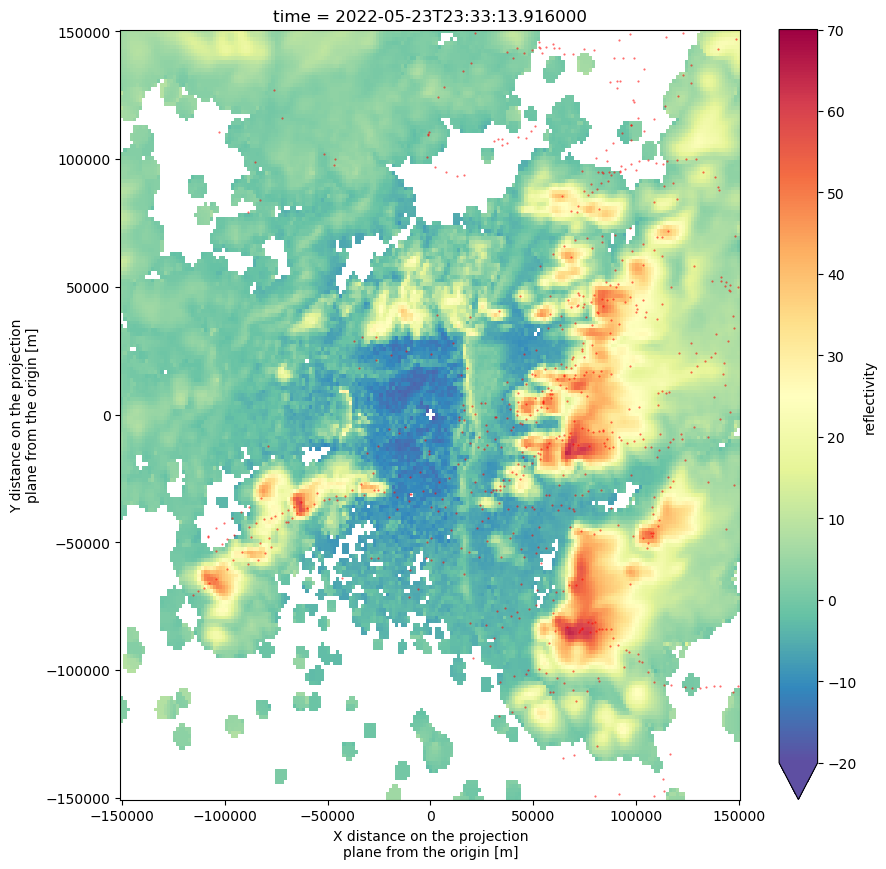

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
maxrefl.isel(time=28).plot(cmap='Spectral_r', vmin=-20, vmax=70)
ax.scatter(Features['projection_x_coordinate'],Features['projection_y_coordinate'],s = 1,c = 'red', marker = '.',alpha = 0.65)

In [97]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 30 
#parameters_segmentation['features']
#parameters_segmentation['field']
#parameters_segmentation['dxy']
#parameters_segmentation['target']
#parameters_segmentation['level']
#parameters_segmentation['max_distance']
#Maximum distance from a marker allowed to be classified as
        #belonging to that cell. Default is None.
#parameters_segmentation['vertical_coord']

#### Features_df=Features.to_dataframe()

# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on reflectivity')
Mask_iris,Features_Precip =tobac.segmentation.segmentation(Features_df,maxrefl_iris,dxy,**parameters_segmentation)

Mask=xr.DataArray.from_iris(Mask_iris)
Mask = Mask.to_dataset()


#Mask,Features_Precip=segmentation(Features,maxrefl,dxy,**parameters_segmentation)
print('segmentation based on reflectivity performed, start saving results to files')
Mask.to_netcdf(os.path.join(savedir,'Mask_Segmentation_refl_KFDX.nc'))                


In [98]:
#Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3 #5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 
parameters_linking['memory']= 3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=25 #0.6 
parameters_linking['d_min']= None #5 


In [45]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:

Track_df=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)

Track = Track_df.to_xarray()

#Track.to_netcdf(os.path.join(savedir,'Track_KFDX.nc'))

NameError: name 'Mask_iris' is not defined

In [100]:
Track

<xarray.Dataset>
Dimensions:                  (index: 653)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 648 649 650 651 652
Data variables: (12/15)
    frame                    (index) int64 5 5 6 6 7 7 8 ... 59 59 59 59 59 59
    idx                      (index) int64 1 2 1 2 1 2 1 ... 31 32 33 35 38 39
    hdim_1                   (index) float64 153.0 163.5 158.0 ... 54.31 67.7
    hdim_2                   (index) float64 147.7 149.0 152.3 ... 134.6 168.9
    num                      (index) int64 10 5 10 20 18 22 ... 209 12 5 34 79
    threshold_value          (index) int64 30 30 30 30 30 30 ... 40 40 40 50 50
    ...                       ...
    projection_y_coordinate  (index) float64 7.949e+04 9.52e+04 ... -4.845e+04
    projection_x_coordinate  (index) float64 7.149e+04 7.356e+04 ... 1.033e+05
    latitude                 (index) float64 35.35 35.49 35.41 ... 34.02 34.19
    longitude                (index) float64 -102.8 -102.8 ... -103.1 -102.5
    cell                     (index) int64 1 2 1 2 1 2 1 ... 115 84 94 -1 108 7
    time_cell                (index) timedelta64[ns] 00:00:00 ... 05:48:06

In [38]:

Track = xr.open_dataset(savedir+"/Track_KFDX.nc")
Features = xr.open_dataset(savedir+"/Features_KFDX.nc")
refl_mask = xr.open_dataset(savedir+"/Mask_Segmentation_refl_KFDX.nc")

# both_ds = xarray.open_dataset(savedir+'/Track_features_merges.nc')

In [39]:
d = tobac.merge_split.merge_split_MEST(Track_df,500., distance=25000.0)

Track = xr.open_dataset(savedir+"/Track_KFDX.nc")
ds = tobac.utils.standardize_track_dataset(Track, refl_mask)#, data['ProjectionCoordinateSystem'])
both_ds = xr.merge([ds, d],compat ='override')

# both_ds = tobac.utils.compress_all(both_ds)
# both_ds.to_netcdf(os.path.join(savedir,'Track_features_merges.nc'))

In [54]:
animation_tobac = tobac.plotting.animation_mask_field(Track, Features, maxrefl_iris, Mask,
                                                  #axis_extent = axis_extent,
                                                  vmin = 0, vmax = 60, extend = 'both', cmap = 'Blues',
                                                  interval = 500, figsize = (10,10),
                                                  plot_outline = True, plot_marker = True, marker_track = 'x', plot_number = True, plot_features = True);

In [67]:
from IPython.display import HTML, Image, display
HTML(animation_tobac.to_html5_video())

AttributeError: 'Dataset' object has no attribute 'extract'

In [ ]:
# IPython.display.Image(animation_tobac)

In [41]:
both_ds

<xarray.Dataset>
Dimensions:                           (feature: 653, time: 60, y: 201, x: 201,
                                       track: 48, cell: 74)
Coordinates:
  * feature                           (feature) int64 1 2 3 4 ... 651 652 653
  * time                              (time) datetime64[ns] 2022-05-23T20:04:...
  * y                                 (y) float64 -1.5e+05 ... 1.5e+05
  * x                                 (x) float64 -1.5e+05 ... 1.5e+05
    lat                               (y, x) float64 ...
    lon                               (y, x) float64 ...
  * track                             (track) float64 0.0 1.0 2.0 ... 46.0 47.0
  * cell                              (cell) int64 -1 1 2 3 ... 115 117 118 119
Data variables: (12/19)
    feature_time_index                (feature) int64 ...
    feature_id_this_frame             (feature) int64 ...
    feature_hdim1_coordinate          (feature) float64 ...
    feature_hdim2_coordinate          (feature) float64 ...
    feature_grid_cell_count           (feature) int64 ...
    feature_threshold_max             (feature) int64 ...
    ...                                ...
    feature_parent_cell_elapsed_time  (feature) timedelta64[ns] ...
    segmentation_mask                 (time, y, x) int32 ...
    cell_parent_track_id              (cell) float64 0.0 1.0 2.0 ... 44.0 44.0
    feature_parent_track_id           (feature) float64 1.0 2.0 1.0 ... 3.0 7.0
    track_child_cell_count            (track) float64 3.0 1.0 1.0 ... 1.0 1.0
    cell_child_feature_count          (cell) float64 83.0 8.0 10.0 ... 3.0 3.0

In [42]:
Features

<xarray.Dataset>
Dimensions:                  (index: 653)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 648 649 650 651 652
Data variables: (12/13)
    frame                    (index) int64 ...
    idx                      (index) int64 ...
    hdim_1                   (index) float64 ...
    hdim_2                   (index) float64 ...
    num                      (index) int64 ...
    threshold_value          (index) int64 ...
    ...                       ...
    time                     (index) datetime64[ns] ...
    timestr                  (index) <U19 ...
    projection_y_coordinate  (index) float64 ...
    projection_x_coordinate  (index) float64 ...
    latitude                 (index) float64 ...
    longitude                (index) float64 ...

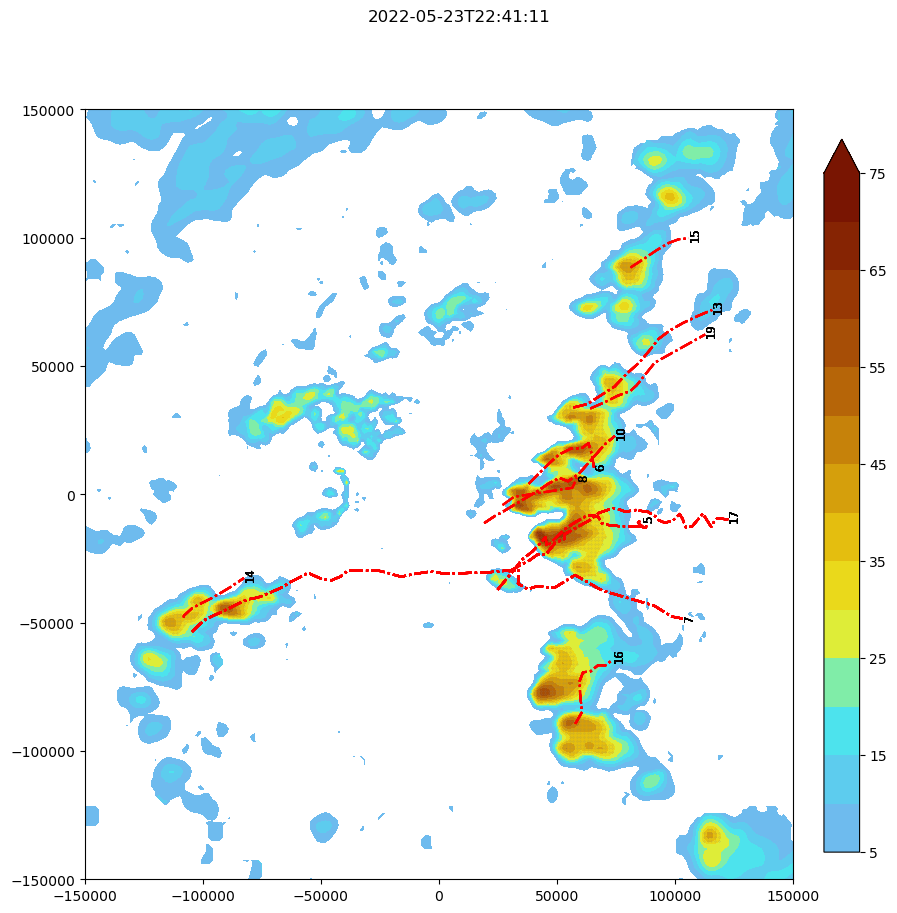

In [151]:
#
frame = 20
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    


for i in Track['cell']:
    if i < 0:
        continue
    #print(i)
    if math.isfinite(i):
        cell_i = np.where(d['feature_parent_cell_id'] == i)
        if (np.nanmax(Features['frame'][cell_i]) >= frame) and (np.nanmin(Features['frame'][cell_i]) <= frame):
            ax.plot(Track['projection_x_coordinate'][cell_i], Track['projection_y_coordinate'][cell_i], '-.',color='r')
            ax.text(Track['projection_x_coordinate'][cell_i][-1],Track['projection_y_coordinate'][cell_i][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue
 





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')

#fig.savefig('/Users/juliabman/Desktop/Seminar_Pictures/tobac_tracking20220524T011012.png')


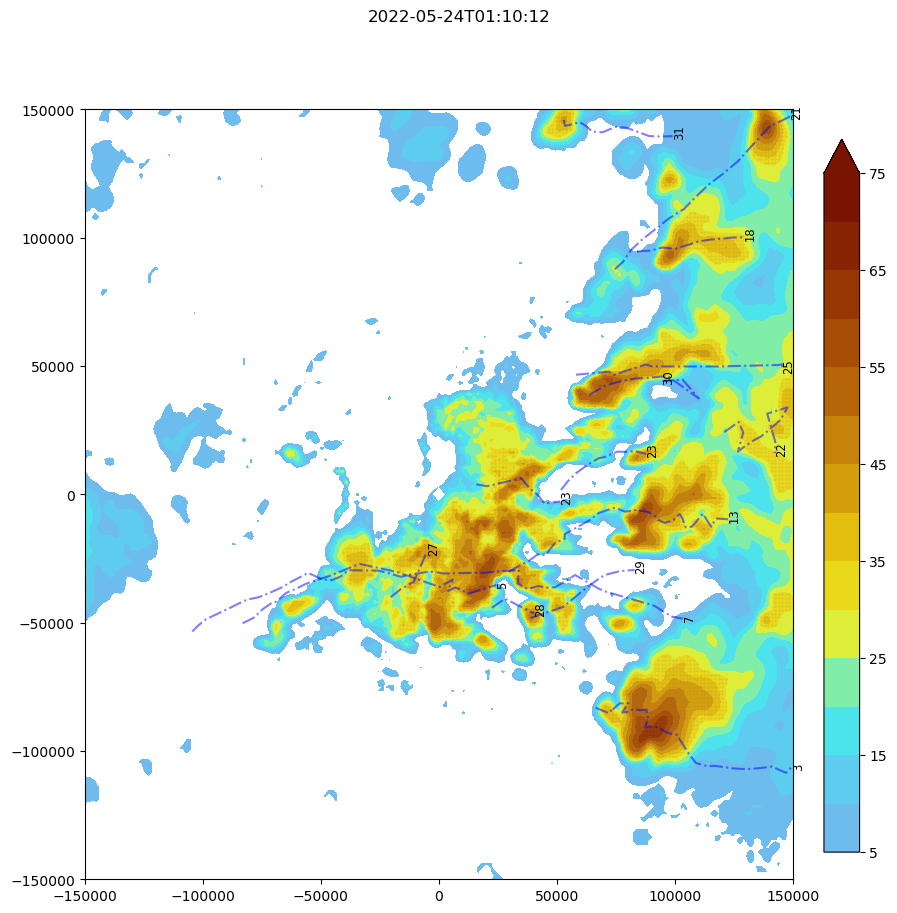

In [47]:
#
frame = 40
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    



for i in d['track']:
    track_i = np.where(d['cell_parent_track_id'] == i.values)
    for cell in d['cell'][track_i]:
        if cell < 0:
            continue

        feature_id = np.where(d['feature_parent_cell_id'] == cell)
        if (frame <= np.nanmax(Features['frame'][feature_id])) and (frame >= np.nanmin(Features['frame'][feature_id])):
            ax.plot(Track['projection_x_coordinate'][feature_id], Track['projection_y_coordinate'][feature_id], '-.',color='b',alpha = 0.5)
            ax.text(Track['projection_x_coordinate'][feature_id][-1],Track['projection_y_coordinate'][feature_id][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')




# Multiple Thresholds

In [101]:
feature_detection_params['threshold'] = [30, 40, 50]

In [102]:
xr_grid_full

<xarray.DataArray 'reflectivity' (time: 60, z: 31, y: 201, x: 201)>
dask.array<open_dataset-reflectivity, shape=(60, 31, 201, 201), dtype=float32, chunksize=(60, 31, 201, 201), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-05-23T20:04:15.913000 ... 2022-05-24T...
  * z        (z) float64 0.0 66.67 133.3 200.0 ... 1.867e+03 1.933e+03 2e+03
    lat      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(201, 201), meta=np.ndarray>
  * y        (y) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05
  * x        (x) float64 -1.5e+05 -1.485e+05 -1.47e+05 ... 1.485e+05 1.5e+05
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    valid_max:      94.5
    valid_min:      -32.0

In [103]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(maxrefl_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

# Features.to_netcdf(os.path.join(savedir,'Features.nc'))
# print('features saved')

starting feature detection based on multiple thresholds
feature detection done


In [104]:
Features_df

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,5,1,152.990650,147.657207,10,30,1,2022-05-23 20:52:31,2022-05-23 20:52:31,79485.975487,71485.810259,35.346473,-102.830728
1,5,2,163.464485,149.040861,5,30,2,2022-05-23 20:52:31,2022-05-23 20:52:31,95196.726868,73561.292150,35.487607,-102.806432
2,6,1,157.970040,152.315031,10,30,3,2022-05-23 21:02:09,2022-05-23 21:02:09,86955.059653,78472.546016,35.413122,-102.752984
3,6,2,167.023351,153.651172,20,30,4,2022-05-23 21:02:09,2022-05-23 21:02:09,100535.026365,80476.758107,35.535083,-102.729529
4,7,1,160.471206,155.353312,18,30,5,2022-05-23 21:07:30,2022-05-23 21:07:30,90706.808623,83029.967706,35.446495,-102.702317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,59,32,98.762694,193.822838,209,40,649,2022-05-24 03:55:52,2022-05-24 03:55:52,-1855.958277,140734.257743,34.607824,-102.081085
649,59,33,91.917792,118.394365,12,40,650,2022-05-24 03:55:52,2022-05-24 03:55:52,-12123.312362,27591.547987,34.524769,-103.317708
650,59,35,109.333384,129.623438,5,40,651,2022-05-24 03:55:52,2022-05-24 03:55:52,14000.076004,44435.156742,34.759107,-103.132475
651,59,38,54.311129,134.625762,34,50,652,2022-05-24 03:55:52,2022-05-24 03:55:52,-68533.306859,51938.643523,34.016533,-103.055368


In [105]:
Features

<xarray.Dataset>
Dimensions:                  (index: 653)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 648 649 650 651 652
Data variables: (12/13)
    frame                    (index) int64 5 5 6 6 7 7 8 ... 59 59 59 59 59 59
    idx                      (index) int64 1 2 1 2 1 2 1 ... 31 32 33 35 38 39
    hdim_1                   (index) float64 153.0 163.5 158.0 ... 54.31 67.7
    hdim_2                   (index) float64 147.7 149.0 152.3 ... 134.6 168.9
    num                      (index) int64 10 5 10 20 18 22 ... 209 12 5 34 79
    threshold_value          (index) int64 30 30 30 30 30 30 ... 40 40 40 50 50
    ...                       ...
    time                     (index) object 2022-05-23 20:52:31 ... 2022-05-2...
    timestr                  (index) object '2022-05-23 20:52:31' ... '2022-0...
    projection_y_coordinate  (index) float64 7.949e+04 9.52e+04 ... -4.845e+04
    projection_x_coordinate  (index) float64 7.149e+04 7.356e+04 ... 1.033e+05
    latitude                 (index) float64 35.35 35.49 35.41 ... 34.02 34.19
    longitude                (index) float64 -102.8 -102.8 ... -103.1 -102.5

In [106]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3 #5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 
parameters_linking['memory']= 3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=30
parameters_linking['d_min']= None #5 

# Track_df=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)

In [107]:
multiple_tracking = tobac.linking_trackpy(Features_df, None, dt=dt,dxy=dxy,**parameters_linking)

Frame 59: 21 trajectories present.


In [108]:
multiple_tracking

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,5,1,152.990650,147.657207,10,30,1,2022-05-23 20:52:31,2022-05-23 20:52:31,79485.975487,71485.810259,35.346473,-102.830728,1,0 days 00:00:00
1,5,2,163.464485,149.040861,5,30,2,2022-05-23 20:52:31,2022-05-23 20:52:31,95196.726868,73561.292150,35.487607,-102.806432,2,0 days 00:00:00
2,6,1,157.970040,152.315031,10,30,3,2022-05-23 21:02:09,2022-05-23 21:02:09,86955.059653,78472.546016,35.413122,-102.752984,1,0 days 00:09:38
3,6,2,167.023351,153.651172,20,30,4,2022-05-23 21:02:09,2022-05-23 21:02:09,100535.026365,80476.758107,35.535083,-102.729529,2,0 days 00:09:38
4,7,1,160.471206,155.353312,18,30,5,2022-05-23 21:07:30,2022-05-23 21:07:30,90706.808623,83029.967706,35.446495,-102.702317,1,0 days 00:14:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,59,32,98.762694,193.822838,209,40,649,2022-05-24 03:55:52,2022-05-24 03:55:52,-1855.958277,140734.257743,34.607824,-102.081085,53,0 days 03:08:00
649,59,33,91.917792,118.394365,12,40,650,2022-05-24 03:55:52,2022-05-24 03:55:52,-12123.312362,27591.547987,34.524769,-103.317708,90,0 days 01:18:56
650,59,35,109.333384,129.623438,5,40,651,2022-05-24 03:55:52,2022-05-24 03:55:52,14000.076004,44435.156742,34.759107,-103.132475,-1,NaT
651,59,38,54.311129,134.625762,34,50,652,2022-05-24 03:55:52,2022-05-24 03:55:52,-68533.306859,51938.643523,34.016533,-103.055368,102,0 days 00:45:36


# 3d Tracking

#### Notice that the field we're tracking on has switched from the 2d composite reflectivity field to the 3D reflectivity field (still in an iris cube). 

In [109]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(grid_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

# Features.to_netcdf(os.path.join(savedir,'Features.nc'))
# print('features saved')

starting feature detection based on multiple thresholds
feature detection done


In [110]:
multiple_tracking = tobac.linking_trackpy(Features_df, None, dt=dt,dxy=dxy,**parameters_linking)

Frame 59: 28 trajectories present.


In [111]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [112]:
# # gps data for first ka
# ka1gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka1_20220523.txt')
# # scan data for first ka
# ka1scan = pd.read_csv('/Users/juliabman/Desktop/research2024/20220523_Ka1_scan_log.txt', dtype=str,
#                      parse_dates=[0])

In [113]:
# lat=ka1gps.Latitude # <== easier way to grab column
# lon=ka1gps.Longitude
# print(lat)
# print(lon)

In [114]:
storm_lat = Features['latitude']
storm_lon = Features['longitude']
time = Features['time']

In [115]:
squeeze_time = time.squeeze()

In [123]:
#squeeze_time

In [124]:
# time_df = pd.DataFrame(time)

In [126]:
# time_df[:1] - time_df[:5]

In [127]:
time_str = Features['timestr']

In [128]:
first_time = time_str[0]

In [129]:
# from datetime import datetime
# datetime.strptime(first_time, '%Y-%m-%dT%H:%M:%SZ')

In [130]:
# trying to get it to remove the first 10 digits of each index (the date)

# for i in time:
#     without_date = time[i][10:]
#     print(without_date)

Convert the time feature into a float via converting it to milliseconds:

In [131]:
time_float = time.astype('datetime64[us]').astype(float)
time_float_proper = time_float/(10**18) 

/var/folders/4f/9s_4__q16tx5t8vmww4mv03h0000gn/T/ipykernel_64135/968129789.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_float = time.astype('datetime64[us]').astype(float)


In [132]:
time_float

<xarray.DataArray 'time' (index: 890)>
array([1.65333915e+18, 1.65333915e+18, 1.65333973e+18, 1.65333973e+18,
       1.65334005e+18, 1.65334005e+18, 1.65334036e+18, 1.65334036e+18,
       1.65334070e+18, 1.65334070e+18, 1.65334104e+18, 1.65334104e+18,
       1.65334104e+18, 1.65334140e+18, 1.65334140e+18, 1.65334176e+18,
       1.65334176e+18, 1.65334176e+18, 1.65334176e+18, 1.65334176e+18,
       1.65334212e+18, 1.65334212e+18, 1.65334212e+18, 1.65334212e+18,
       1.65334212e+18, 1.65334288e+18, 1.65334288e+18, 1.65334288e+18,
       1.65334288e+18, 1.65334288e+18, 1.65334288e+18, 1.65334327e+18,
       1.65334327e+18, 1.65334327e+18, 1.65334327e+18, 1.65334327e+18,
       1.65334327e+18, 1.65334327e+18, 1.65334327e+18, 1.65334367e+18,
       1.65334367e+18, 1.65334367e+18, 1.65334367e+18, 1.65334367e+18,
       1.65334367e+18, 1.65334367e+18, 1.65334408e+18, 1.65334408e+18,
       1.65334408e+18, 1.65334408e+18, 1.65334408e+18, 1.65334408e+18,
       1.65334408e+18, 1.65334408e+18, 1.65334449e+18, 1.65334449e+18,
       1.65334449e+18, 1.65334449e+18, 1.65334449e+18, 1.65334449e+18,
       1.65334449e+18, 1.65334449e+18, 1.65334449e+18, 1.65334449e+18,
       1.65334489e+18, 1.65334489e+18, 1.65334489e+18, 1.65334489e+18,
       1.65334489e+18, 1.65334489e+18, 1.65334489e+18, 1.65334489e+18,
       1.65334489e+18, 1.65334489e+18, 1.65334489e+18, 1.65334489e+18,
       1.65334567e+18, 1.65334567e+18, 1.65334567e+18, 1.65334567e+18,
...
       1.65336335e+18, 1.65336335e+18, 1.65336335e+18, 1.65336335e+18,
       1.65336335e+18, 1.65336335e+18, 1.65336335e+18, 1.65336335e+18,
       1.65336335e+18, 1.65336335e+18, 1.65336335e+18, 1.65336335e+18,
       1.65336335e+18, 1.65336335e+18, 1.65336335e+18, 1.65336335e+18,
       1.65336335e+18, 1.65336335e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336413e+18, 1.65336413e+18,
       1.65336413e+18, 1.65336413e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18, 1.65336455e+18, 1.65336455e+18,
       1.65336455e+18, 1.65336455e+18])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 882 883 884 885 886 887 888 889

In [133]:
time2 = time_float_proper.squeeze()

In [134]:
time2[-1] - time2[0]

<xarray.DataArray 'time' ()>
array(2.5401e-05)

In [135]:
time_1 = morton_data_xr['time'][-1].astype(float)
time_2 = morton_data_xr['time'][0].astype(float)
time_3 = morton_data_xr['time'].astype(float)

In [136]:
#measure(lat, lon, storm_lat, storm_lon)

In [137]:
from math import sin, cos, sqrt, atan2, radians

In [138]:
def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    #print(d)
    return d / (time2 - time1)

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

In [139]:
#calc_velocity(lat,lon,storm_lat,storm_lon,time1,time2)

In [140]:
velocity1=[]
direction1=[]
for i in np.arange(0,len(time_3)-1):
    velocity = calc_velocity(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i],
                             time_3[i],time_3[i+1])
    velocity1.append(velocity)
    direction = get_bearing(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i+1])
    direction1.append(direction)
velocity1 = np.append([np.nan],velocity1)
direction1 = np.append([np.nan],direction1)

In [141]:
velocity1

array([           nan, 2.67447422e-08, 1.39755634e-08, 2.30860316e-08,
       1.67984218e-08, 2.20562356e-08, 1.70431882e-08, 3.97199906e-08,
       3.02068829e-08, 3.74341315e-08, 5.76477716e-07, 5.02083278e-07,
       3.67748459e-08, 5.30094355e-07, 2.76886488e-07, 5.35938773e-07,
       1.89720096e-08, 4.69638488e-07, 5.12423554e-07, 5.73120650e-07,
       2.87383659e-07, 3.31827668e-08, 4.66945075e-07, 3.91357162e-07,
       4.44733098e-07, 2.09158918e-07, 1.44435302e-07, 1.99808422e-07,
       1.25665300e-07, 2.28986662e-07, 5.85472334e-07, 6.35658916e-08,
       1.64129878e-07, 3.37077223e-07, 1.34957853e-08, 5.75648588e-07,
       2.78666177e-08, 9.86354182e-08, 2.28361216e-08, 8.21263976e-08,
       6.55065027e-09, 9.41728058e-08, 3.83512622e-07, 2.81652527e-07,
       2.16868030e-08, 1.50019020e-07, 1.53058460e-07, 2.35746698e-07,
       1.18879985e-07, 1.69559614e-08, 4.86424057e-08, 1.44451718e-07,
       2.66656821e-08, 1.59079981e-07, 1.64049964e-07, 5.05519490e-08,
      

In [142]:
direction1

array([         nan, 186.53633633, 325.98024997, 187.00169854,
       343.59335751, 190.0125868 , 345.99519154, 176.38152328,
       328.78325289, 182.26710311,  21.34991231, 203.03382152,
       180.13640714,  21.06212832, 199.71962504,  19.87114482,
       210.78218228, 200.02309681,  21.64257759, 200.24190652,
        20.11845515, 205.30055355, 200.77304869,  27.3119166 ,
       204.82827748,  25.53733746,  31.15981789,   1.57049962,
       179.32809836, 205.12444196,  20.2824311 , 202.56829289,
       177.45519823, 209.84657991, 226.22380398,  21.89829066,
       204.86397962, 167.2897862 , 219.97215692, 341.03347465,
        92.7447432 , 246.48365456, 338.76942451, 148.55719018,
       224.71968344,   5.94307721, 310.38834262, 115.74798579,
       249.02074269, 228.9422915 , 195.86172991,  16.71669902,
       221.98333062,   6.06675325, 310.72044215, 125.75092628,
       129.69022068, 109.55711197, 246.02924566, 202.09114301])

In [143]:
velocity_df = pd.DataFrame(velocity1)

In [144]:
new_v1 = velocity_df.dropna()

In [145]:
average_velocity_nano = np.average(new_v1)

In [146]:
average_velocity_nano

1.8680460096723882e-07

In [147]:
average_velocity_seconds = average_velocity_nano * (1e9)

In [148]:
average_velocity_seconds # meters per second

186.80460096723883

In [ ]:
direction_df = pd.DataFrame(direction1)

In [ ]:
new_d1 = direction_df.dropna()

In [ ]:
average_direction = np.average(new_d1)

In [ ]:
average_direction

The average velocity was computed over 7 hours as they begin scanning at 20 UTC and stop at 03 UTC... such a long time interval.. is it even the same storm 7 hours later that its tracking? 

Ive been using the morton data xarray for the time instead of the tobac one since i cant use the time from tobac... is that messing things up? also what are even the units for my velocity??